In [1]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import dlib

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.drawing.image import Image as OpenpyxlImage
import tempfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/sample\ data

/content/drive/MyDrive/sample data


In [4]:
pwd

'/content/drive/MyDrive/sample data'

In [5]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-02-22 15:16:56--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  8.57MB/s    in 16s     

2024-02-22 15:17:13 (3.79 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [7]:
def find_intersection(line1_point1, line1_point2, line2_point1, line2_point2):
    """
    Finds the intersection point of two lines given by two points on each line.

    Parameters:
    - line1_point1, line1_point2: Points on the first line (numpy arrays or tuples).
    - line2_point1, line2_point2: Points on the second line (numpy arrays or tuples).

    Returns:
    - A tuple (x, y) representing the intersection point.
    """
    x1, y1 = line1_point1
    x2, y2 = line1_point2
    x3, y3 = line2_point1
    x4, y4 = line2_point2

    # Calculating the determinant of the system
    den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    # If the lines are parallel (denominator is 0), there is no intersection
    if den == 0:
        return None

    # Calculating the intersection point
    intersect_x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / den
    intersect_y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / den

    return (intersect_x, intersect_y)


In [12]:
def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

In [13]:
# Load the pre-trained model for facial landmark detection
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

# Load the image
image = cv2.imread('yuz_a.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray, 1)

# Initialize the lists to hold point descriptions and their corresponding distances
points = []
distances = []

for face in faces:
    # Determine the facial landmarks for the face region
    shape = predictor(gray, face)

    # Get the coordinates for landmarks 28 and 30
    point_28 = (shape.part(27).x, shape.part(27).y)
    point_31 = (shape.part(30).x, shape.part(30).y)

    cv2.circle(image, (point_28), 3, (255, 0, 0), -1)  # Draws a red dot
    cv2.circle(image, (point_31), 3, (255, 0, 0), -1)  # Draws a red dot

    # Calculate the direction vector of the line
    direction = np.array([point_31[0] - point_28[0], point_31[1] - point_28[1]])

    # Extend the line to the top and bottom of the face
    top_point = np.array(point_28) - direction * 1.5   # Arbitrary large number
    bottom_point = np.array(point_31) + direction * 2.5 # Arbitrary large number

    # Draw the extended line
    cv2.line(image, tuple(top_point.astype(int)), tuple(bottom_point.astype(int)), (255, 0, 0), 2)


    # Calculate and draw symmetry for each facial landmark
    for i in ([0,1,2,3,4, 5, 6, 7]):
        original_point = (shape.part(i).x, shape.part(i).y)

        cv2.circle(image, original_point, 3, (0, 255, 0), -1)
        facial_point = np.array([shape.part(i).x, shape.part(i).y])

        perp_direction = np.array([-direction[1], direction[0]])  # Rotate the direction vector by 90 degrees
        end_point = facial_point - perp_direction * 3
        #cv2.circle(image, end_point, 3, (0,0,255), -1)
        #cv2.line(image, tuple(facial_point.astype(int)), tuple(end_point.astype(int)), (0, 255, 0), 2)

        """Finds the intersection of two lines given in form of ([x1, y1], [x2, y2])."""
        intersect_point  = find_intersection(top_point, bottom_point, facial_point, end_point)
        intersect_point = np.array(intersect_point).astype(int)

        cv2.circle(image, intersect_point, 3, (0,0,255), -1)
        cv2.line(image, tuple(facial_point.astype(int)), tuple(intersect_point), (0, 255, 0), 2)

        distance = calculate_distance(facial_point, intersect_point)
        print(f'Distance between facial point \'{i}\' and its intersection point: {distance}')

        points.append(f'Point {i}')
        distances.append(distance)

    for i in ([9, 10,11,12,13,14,15,16]):
        original_point = (shape.part(i).x, shape.part(i).y)

        cv2.circle(image, original_point, 3, (0, 255, 0), -1)
        facial_point = np.array([shape.part(i).x, shape.part(i).y])

        perp_direction = np.array([direction[1], -direction[0]])  # Rotate the direction vector by 270 degrees
        end_point = facial_point - perp_direction * 3
        #cv2.circle(image, end_point, 3, (0,0,255), -1)
        #cv2.line(image, tuple(end_point.astype(int)), tuple(facial_point.astype(int)), (0, 0, 0), 2)

        intersect_point  = find_intersection(top_point, bottom_point, end_point, facial_point)
        intersect_point = np.array(intersect_point).astype(int)

        cv2.circle(image, intersect_point, 3, (0,0,255), -1)
        cv2.line(image, tuple(intersect_point), tuple(facial_point.astype(int)), (0, 255, 0), 2)

        distance = calculate_distance(facial_point, intersect_point)
        print(f'Distance between facial point \'{i}\' and its intersection point: {distance}')

        points.append(f'Point {i}')
        distances.append(distance)


print(f'points:{points}')
print(f'distance:{distances}')

Distance between facial point '0' and its intersection point: 515.8342757126557
Distance between facial point '1' and its intersection point: 523.8950276534413
Distance between facial point '2' and its intersection point: 509.76268988618614
Distance between facial point '3' and its intersection point: 491.7570538385799
Distance between facial point '4' and its intersection point: 466.58011102060493
Distance between facial point '5' and its intersection point: 410.25967386522404
Distance between facial point '6' and its intersection point: 320.8067954392488
Distance between facial point '7' and its intersection point: 197.12178976460214
Distance between facial point '9' and its intersection point: 114.5294721894762
Distance between facial point '10' and its intersection point: 232.24340679554285
Distance between facial point '11' and its intersection point: 328.76283244916846
Distance between facial point '12' and its intersection point: 394.03553139279205
Distance between facial point 

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'Point': points,
    'Distance': distances
})

# Save DataFrame to Excel
excel_path = 'facemetrics_all_patients.xlsx'
df.to_excel(excel_path, index=False)

# Save your image to a temporary file
temp_image_path = tempfile.mktemp(suffix='.png')
cv2.imwrite(temp_image_path, image)  # Assuming 'image' is your cv2 image

# Load the workbook and get the active sheet
wb = load_workbook(excel_path)
ws = wb.active

# Insert the image into the Excel file
img = OpenpyxlImage(temp_image_path)
# Adjust as needed; 'A' + str(len(distances) + 2) positions the image below the data
img.anchor = 'A' + str(len(distances) + 2)
ws.add_image(img)

# Save the workbook
wb.save(excel_path)

# Optionally, clean up the temporary image file
os.remove(temp_image_path)

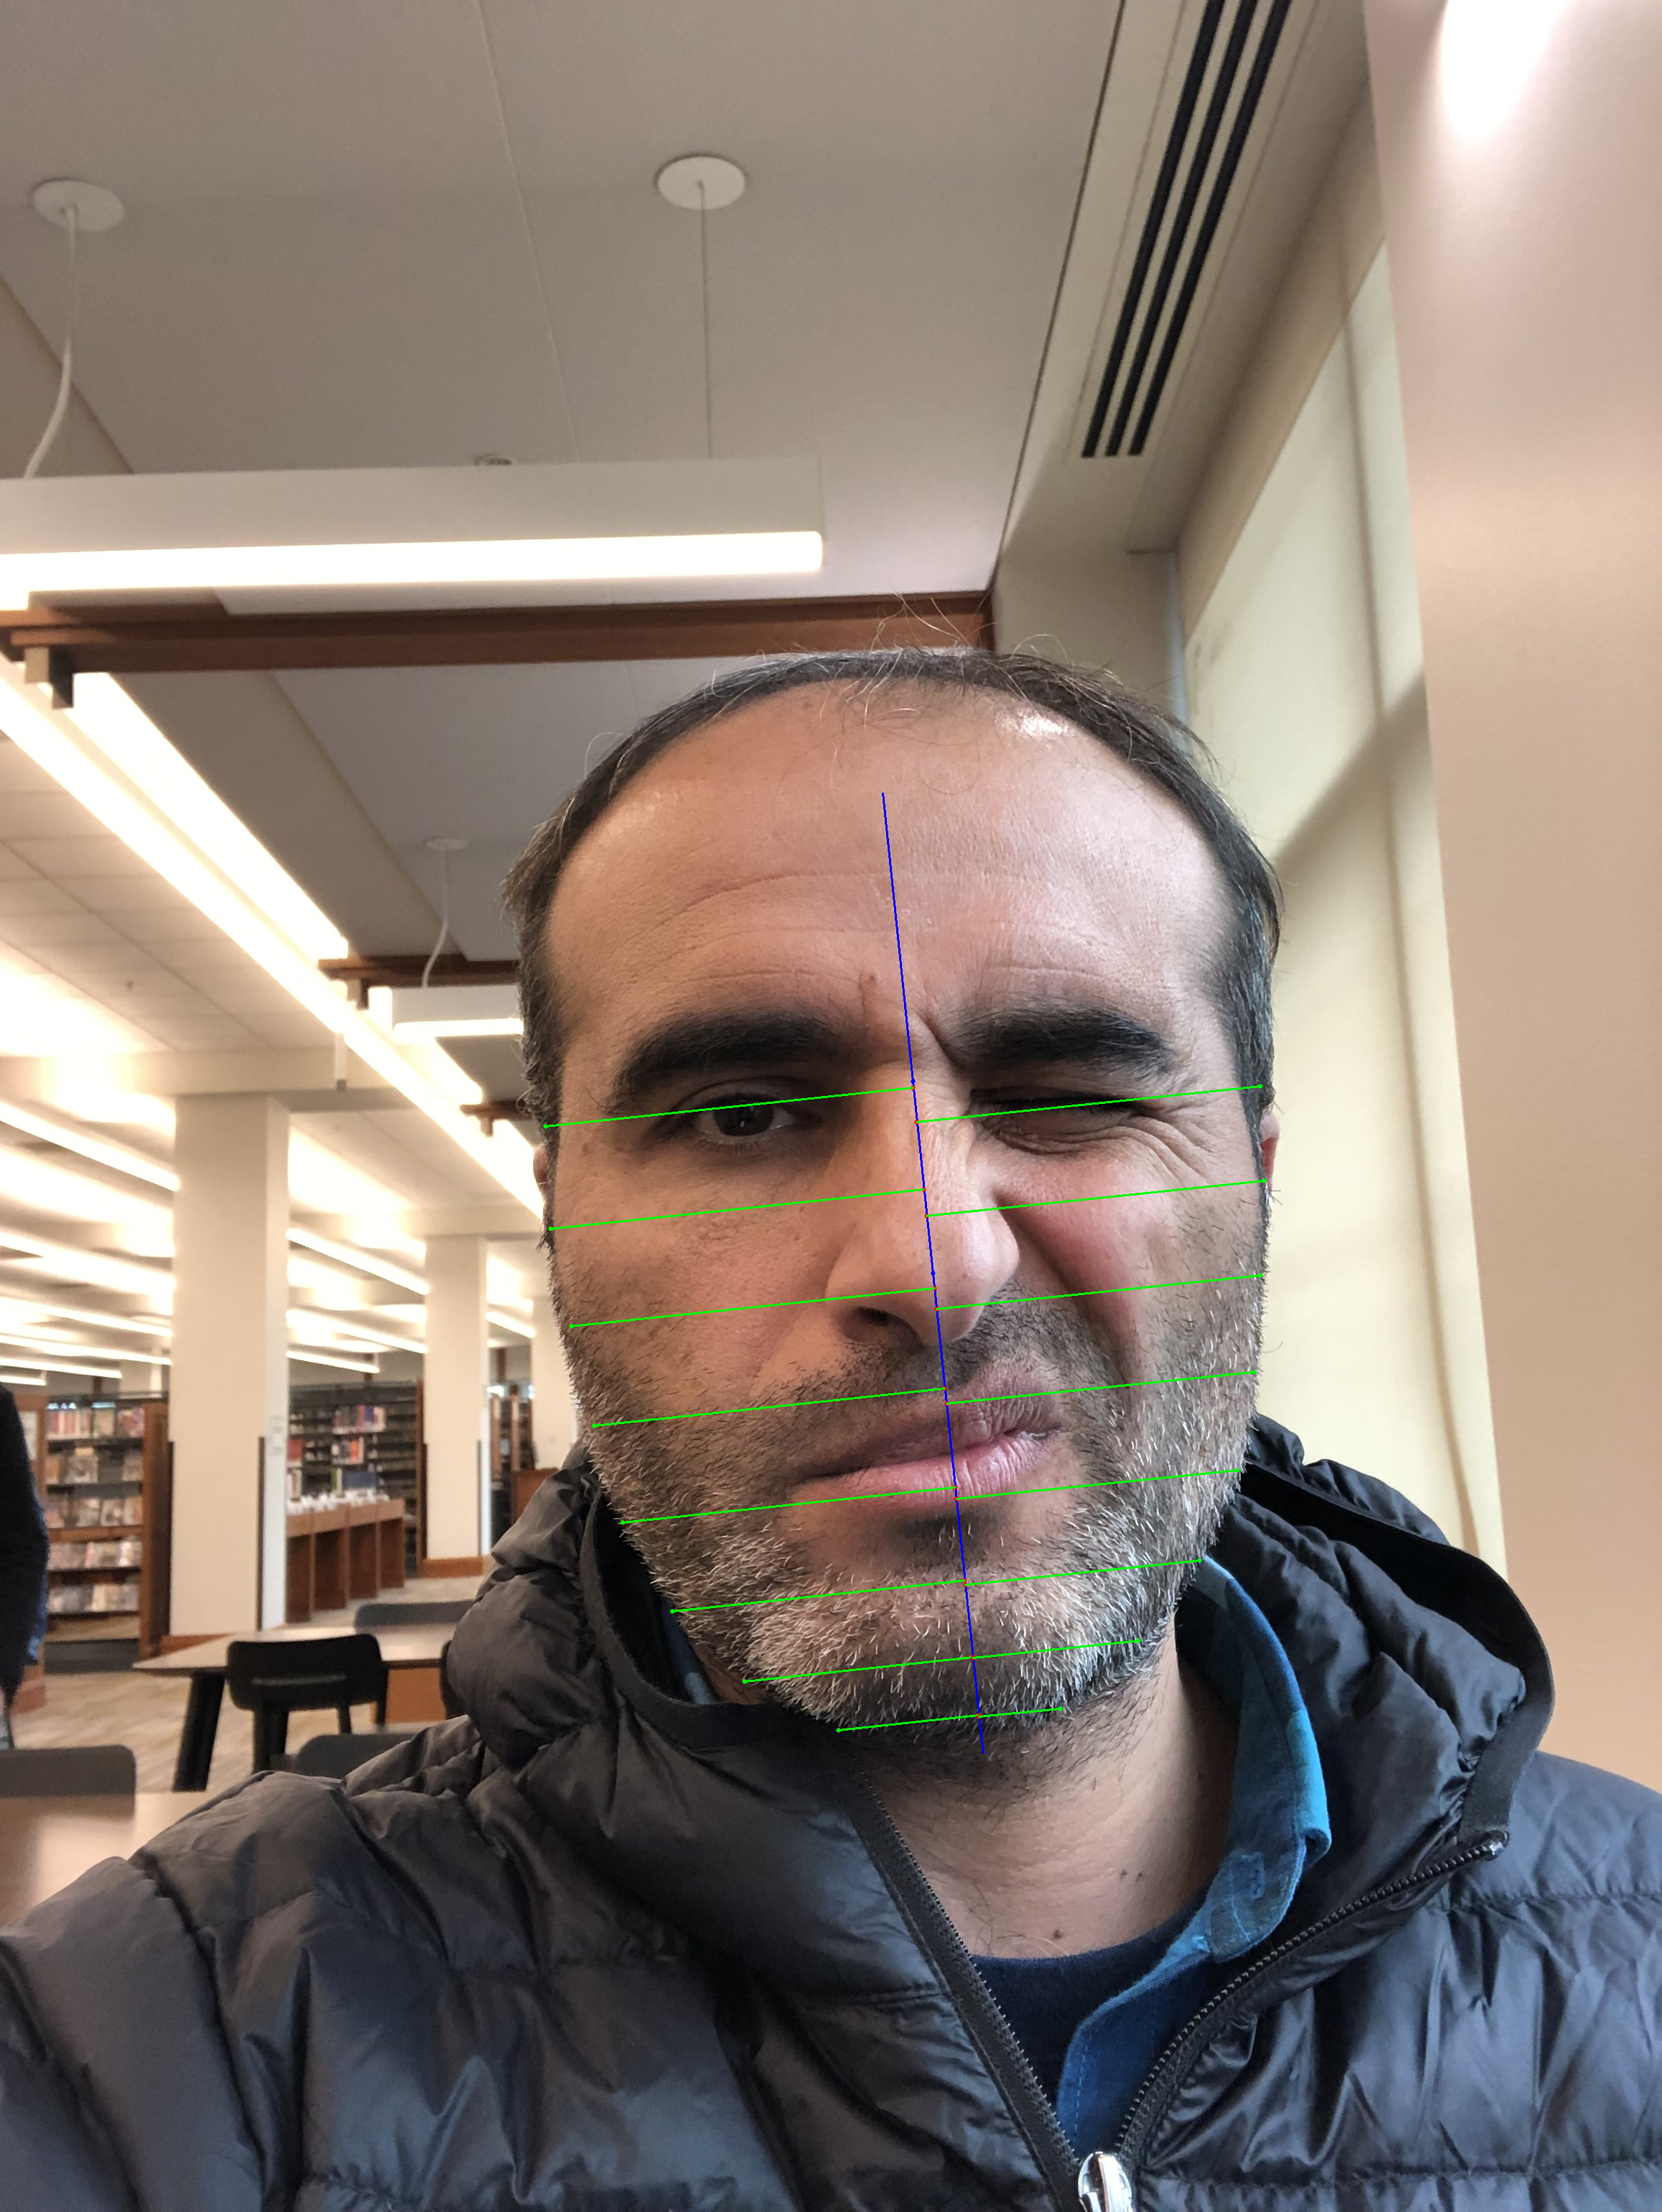

In [14]:
# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
class FacialLandmarkProcessor:
    def __init__(self, predictor_path):
        self.predictor_path = predictor_path
        self.predictor = dlib.shape_predictor(predictor_path)
        self.detector = dlib.get_frontal_face_detector()

    def find_intersection(self, line1_point1, line1_point2, line2_point1, line2_point2):
        x1, y1 = line1_point1
        x2, y2 = line1_point2
        x3, y3 = line2_point1
        x4, y4 = line2_point2

        # Calculating the determinant of the system
        den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

        # If the lines are parallel (denominator is 0), there is no intersection
        if den == 0:
            return None

        # Calculating the intersection point
        intersect_x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / den
        intersect_y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / den

        return (intersect_x, intersect_y)


    def calculate_distance(self, p1, p2):
        """Calculate the Euclidean distance between two points."""
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    def process_image(self, image_path):
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray, 1)

        points = []
        distances = []


        for face in faces:
            shape = self.predictor(gray, face)
            # Get the coordinates for landmarks 28 and 30
            point_28 = (shape.part(27).x, shape.part(27).y)
            point_31 = (shape.part(30).x, shape.part(30).y)

            cv2.circle(image, (point_28), 3, (255, 0, 0), -1)  # Draws a red dot
            cv2.circle(image, (point_31), 3, (255, 0, 0), -1)  # Draws a red dot

            # Calculate the direction vector of the line
            direction = np.array([point_31[0] - point_28[0], point_31[1] - point_28[1]])

            # Extend the line to the top and bottom of the face
            top_point = np.array(point_28) - direction * 1.5   # Arbitrary large number
            bottom_point = np.array(point_31) + direction * 2.5 # Arbitrary large number

            # Draw the extended line
            cv2.line(image, tuple(top_point.astype(int)), tuple(bottom_point.astype(int)), (255, 0, 0), 2)


            # Calculate and draw symmetry for each facial landmark
            for i in ([0,1,2,3,4, 5, 6, 7]):
                original_point = (shape.part(i).x, shape.part(i).y)

                cv2.circle(image, original_point, 3, (0, 255, 0), -1)
                facial_point = np.array([shape.part(i).x, shape.part(i).y])

                perp_direction = np.array([-direction[1], direction[0]])  # Rotate the direction vector by 90 degrees
                end_point = facial_point - perp_direction * 3
                #cv2.circle(image, end_point, 3, (0,0,255), -1)
                #cv2.line(image, tuple(facial_point.astype(int)), tuple(end_point.astype(int)), (0, 255, 0), 2)

                """Finds the intersection of two lines given in form of ([x1, y1], [x2, y2])."""
                intersect_point  = self.find_intersection(top_point, bottom_point, facial_point, end_point)
                intersect_point = np.array(intersect_point).astype(int)

                cv2.circle(image, intersect_point, 3, (0,0,255), -1)
                cv2.line(image, tuple(facial_point.astype(int)), tuple(intersect_point), (0, 255, 0), 2)

                distance = self.calculate_distance(facial_point, intersect_point)
                print(f'Distance between facial point \'{i}\' and its intersection point: {distance}')

                points.append(f'Point {i}')
                distances.append(distance)

            for i in ([9, 10,11,12,13,14,15,16]):
                original_point = (shape.part(i).x, shape.part(i).y)

                cv2.circle(image, original_point, 3, (0, 255, 0), -1)
                facial_point = np.array([shape.part(i).x, shape.part(i).y])

                perp_direction = np.array([direction[1], -direction[0]])  # Rotate the direction vector by 270 degrees
                end_point = facial_point - perp_direction * 3
                #cv2.circle(image, end_point, 3, (0,0,255), -1)
                #cv2.line(image, tuple(end_point.astype(int)), tuple(facial_point.astype(int)), (0, 0, 0), 2)

                intersect_point  = self.find_intersection(top_point, bottom_point, end_point, facial_point)
                intersect_point = np.array(intersect_point).astype(int)

                cv2.circle(image, intersect_point, 3, (0,0,255), -1)
                cv2.line(image, tuple(intersect_point), tuple(facial_point.astype(int)), (0, 255, 0), 2)

                distance = self.calculate_distance(facial_point, intersect_point)
                print(f'Distance between facial point \'{i}\' and its intersection point: {distance}')

                points.append(f'Point {i}')
                distances.append(distance)
        print(len(distances))

        # Return the modified image, points list, and distances list
        return image, points, distances


    def calculate_symetry(self, distances):
        distances = np.array(distances)

        # Calculate symmetry using vectorized operations
        symmetries = (1 - distances[:8] / distances[15:7:-1]) ** 2
        symmetry_metric = np.mean(symmetries)

        return symmetry_metric


    def save_data_to_excel(self, image_paths, excel_path):
        wb = load_workbook(excel_path) if os.path.exists(excel_path) else Workbook()
        for idx, image_path in enumerate(image_paths):
            image, points, distances = self.process_image(image_path)

            symetry_metric = self.calculate_symetry(distances)

            ws = wb.create_sheet(f"Face {idx + 1}")
            df = pd.DataFrame({'Point': points, 'Distance': distances, 'Symetry_Value': symetry_metric})
            for r in dataframe_to_rows(df, index=False, header=True):
                ws.append(r)
            temp_image_path = tempfile.mktemp(suffix='.png')
            cv2.imwrite(temp_image_path, image)
            img = OpenpyxlImage(temp_image_path)
            img.anchor = 'A' + str(len(distances) + 2)
            ws.add_image(img)

        wb.save(excel_path)


# Example usage
predictor_path = 'shape_predictor_68_face_landmarks.dat'
processor = FacialLandmarkProcessor(predictor_path)
image_paths = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg','9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg']
excel_path = 'facemetrics_all_patients.xlsx'
processor.save_data_to_excel(image_paths, excel_path)


Distance between facial point '0' and its intersection point: 350.0014285685131
Distance between facial point '1' and its intersection point: 340.00147058505496
Distance between facial point '2' and its intersection point: 328.0015243867016
Distance between facial point '3' and its intersection point: 314.00159235265033
Distance between facial point '4' and its intersection point: 292.00171232374646
Distance between facial point '5' and its intersection point: 250.00199999200007
Distance between facial point '6' and its intersection point: 194.0
Distance between facial point '7' and its intersection point: 124.0
Distance between facial point '9' and its intersection point: 48.010415536631214
Distance between facial point '10' and its intersection point: 125.00399993600205
Distance between facial point '11' and its intersection point: 190.0026315607234
Distance between facial point '12' and its intersection point: 247.00809703327542
Distance between facial point '13' and its intersectio